In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 회원정보 파일 경로 리스트
member_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201807_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

# 2. 신용정보 파일 경로 리스트
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

# 3. 기준년월 컬럼 추가 및 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# 4. 데이터 로딩
member_df = load_and_merge_parquet(member_file_paths)
marketing_df = load_and_merge_parquet(marketing_file_paths)

# 5. Segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in member_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)
segment_col = segment_col_candidates[-1]

if member_df[segment_col].dtype == 'object':
    member_df[segment_col] = member_df[segment_col].astype('category').cat.codes

# 6. 두 DataFrame을 'ID'와 '기준년월' 기준으로 inner join (병합 아님, 동기화)
target_cols = ['ID', '기준년월', segment_col]
member_target = member_df[target_cols]
combined_df = pd.merge(member_target, marketing_df, on=['ID', '기준년월'], how='inner')

# 7. 분석 대상 numeric 컬럼만 선택
numeric_cols = [col for col in combined_df.select_dtypes(include=['int64', 'float64']).columns if col != segment_col]

# 8. 결측치 제거 및 std=0 컬럼 제거
clean_df = combined_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]

# 9. 결측치 수 계산
missing_dict = {
    col: combined_df[col].isnull().sum()
    for col in numeric_cols
}

# 10. 이상치 수 계산 (IQR 기준)
outlier_dict = {}
for col in numeric_cols:
    Q1 = combined_df[col].quantile(0.25)
    Q3 = combined_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((combined_df[col] < lower_bound) | (combined_df[col] > upper_bound)).sum()
    outlier_dict[col] = outliers

# 11. 상관계수 계산
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in numeric_cols
}

# 12. 결과 정리
corr_df = pd.DataFrame({
    '컬럼명': list(corr_dict.keys()),
    '상관계수': list(corr_dict.values()),
    '결측치 수': [missing_dict[col] for col in corr_dict.keys()],
    '이상치 수': [outlier_dict[col] for col in corr_dict.keys()]
})

corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 13. 스타일링 출력
from IPython.display import display
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled)


사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수,결측치 수,이상치 수
1,카드이용한도금액,-0.284751,0,155531
24,카드이용한도금액_B2M,-0.282935,0,158297
23,카드이용한도금액_B1M,-0.282312,0,157572
2,CA한도금액,-0.280853,0,55136
5,CA이자율_할인전,-0.106931,0,544496
0,최초한도금액,-0.088260,0,328716
10,RV약정청구율,0.079446,0,454949
7,RV일시불이자율_할인전,-0.074411,0,269448
8,RV현금서비스이자율_할인전,-0.071617,0,452238
9,RV신청일자,0.057772,1951236,0


In [ ]:
# [1] 0.3 이하 상관관계 컬럼만 필터링
corr_under_02 = corr_df[abs(corr_df['상관계수']) <= 0.3]

# [2] 변수 리스트 추출
low_corr_vars = corr_under_02['컬럼명'].unique().tolist()

# [3] clean_df에서 추출
eda_df = clean_df[low_corr_vars + ['Segment']]

# [4] 저장
eda_df.to_csv("신용정보2_low_corr_segment_data.csv", index=False, encoding='utf-8-sig')
print("✅ 저장 완료: low_corr_segment_data.csv")


In [29]:
eda_df = clean_df[low_corr_vars + [segment_col]]



In [30]:
display(eda_df.groupby(segment_col).mean().style
        .background_gradient(cmap='YlGnBu')
        .set_caption("Segment별 평균 (상관계수 0.3 이하 변수만)"))



,카드이용한도금액,카드이용한도금액_B2M,카드이용한도금액_B1M,CA한도금액,CA이자율_할인전,최초한도금액,RV약정청구율,RV일시불이자율_할인전,RV현금서비스이자율_할인전,RV신청일자,일시상환론한도금액,한도증액금액_R12M,일시불ONLY전환가능여부,상향가능CA한도금액,CL이자율_할인전,상향가능한도금액,강제한도감액후경과월,RV최소결제비율,강제한도감액횟수_R12M,월상환론한도금액,월상환론상향가능한도금액,강제한도감액금액_R12M,자발한도감액금액_R12M,한도증액후경과월,한도심사거절후경과월,연체감액여부_R3M,한도요청거절건수,rv최초시작후경과일,시장단기연체여부_R6M,한도심사요청후경과월,시장단기연체여부_R3M,자발한도감액후경과월,특별한도보유여부_R3M
Segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,199450.150000,197090.594444,196399.200000,57442.611111,17.448815,13337.400000,83.038641,13.004903,15.617430,20144884.983333,58143.883333,0.377778,0.861111,1.288889,15.402126,4.627778,11.422222,11.999976,0.261111,111851.405556,1.800000,0.261111,0.000000,10.794444,3.000000,0.000000,0.000000,1424.011111,0.000000,3.000000,0.000000,12.000000,0.000000
1,169630.255319,165953.893617,165311.893617,42444.106383,17.824016,7344.893617,88.433010,13.139069,16.283586,20159221.000000,65320.553191,0.617021,0.617021,0.765957,15.531163,2.659574,11.489362,11.808487,0.042553,119729.531915,0.000000,0.021277,0.000000,10.340426,3.000000,0.000000,0.000000,832.851064,0.000000,3.000000,0.000000,12.000000,0.000000
2,98004.352671,97425.928865,97403.722055,31766.025519,17.144787,7326.248835,87.085922,13.252806,15.810212,20146934.478988,41207.934666,0.186609,0.753790,0.861356,15.619205,3.113229,11.449118,13.208821,0.195690,99468.866984,1.263752,0.200525,0.001796,11.335923,2.999620,0.009289,0.000207,170580.177043,0.000000,2.999758,0.000000,11.998791,0.000000
3,69372.394476,68933.883281,68837.394696,23579.200242,16.668098,4732.097688,87.362611,13.062683,15.508020,20147882.940713,35657.597123,0.204755,0.796069,0.897886,15.436973,3.380146,11.484116,13.052848,0.162906,100442.268742,1.717806,0.161478,0.001482,11.120958,2.999923,0.011234,0.000044,132011.550200,0.000000,2.999978,0.000000,11.996837,0.000011
4,50571.660698,50817.266358,50759.628952,17539.328724,16.190916,3588.013744,92.136276,12.666887,15.122907,20150685.872912,31426.066122,0.154259,0.821066,0.783241,15.262918,3.025914,11.338035,12.913801,0.161899,97183.229142,1.657286,0.191064,0.001120,11.241914,2.999945,0.009132,0.000040,185089.946596,0.000043,2.999921,0.000006,11.997961,0.000006


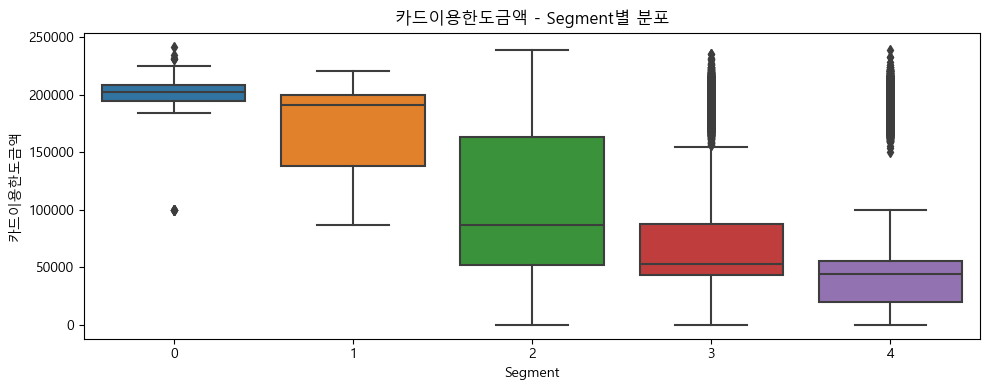

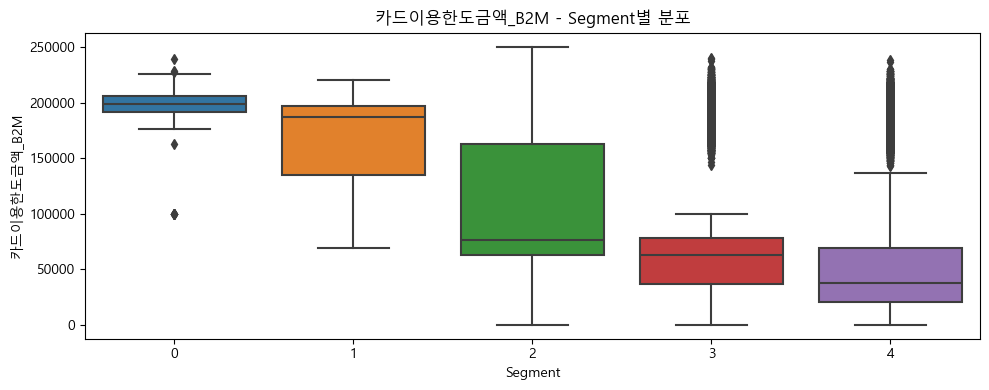

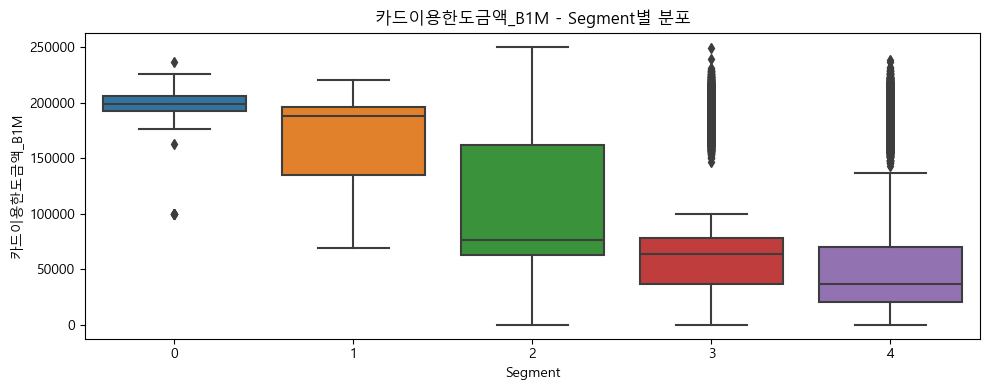

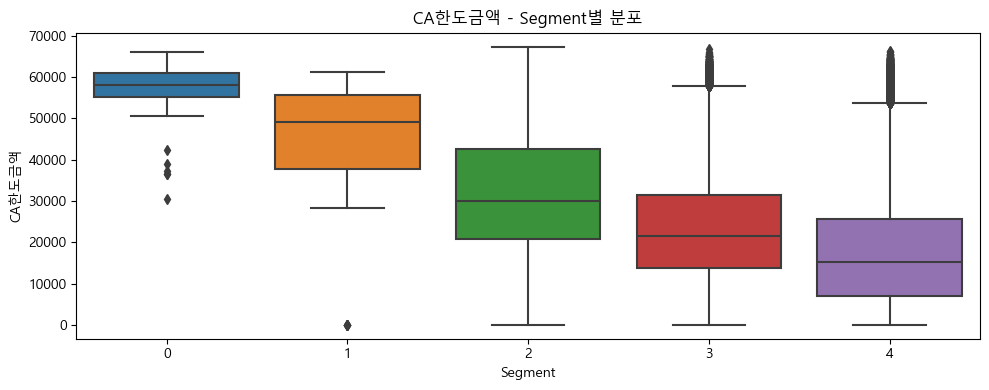

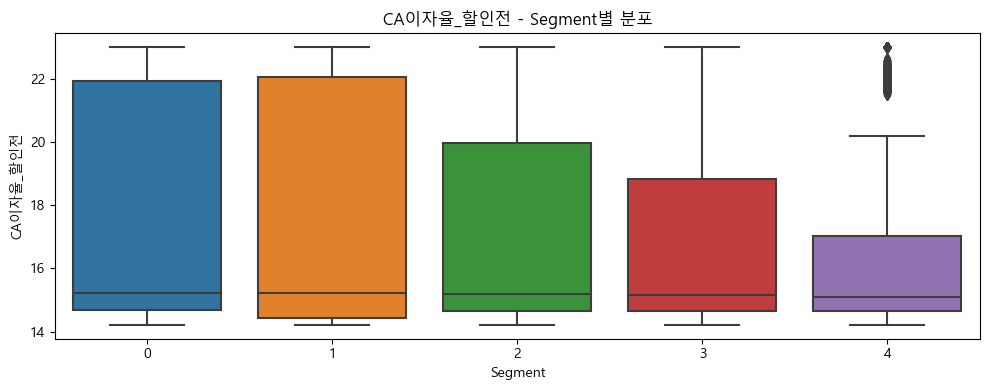

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in low_corr_vars[:5]:  # 전체 말고 예시로 5개
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=segment_col, y=col, data=eda_df)
    plt.title(f"{col} - Segment별 분포")
    plt.tight_layout()
    plt.show()


C:\Users\HR\AppData\Local\Temp\ipykernel_24964\2394508156.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=eda_df, x=segment_col, y=col, estimator='mean', ci='sd')


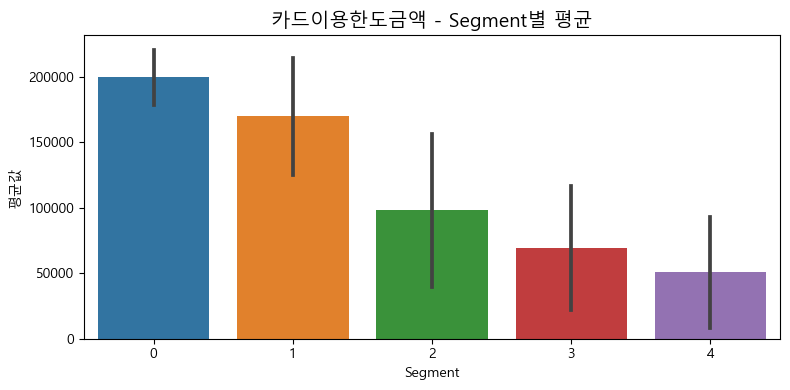

C:\Users\HR\AppData\Local\Temp\ipykernel_24964\2394508156.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=eda_df, x=segment_col, y=col, estimator='mean', ci='sd')


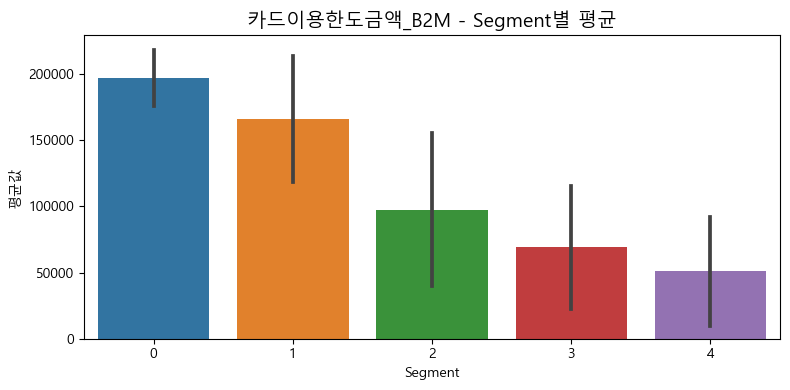

C:\Users\HR\AppData\Local\Temp\ipykernel_24964\2394508156.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=eda_df, x=segment_col, y=col, estimator='mean', ci='sd')


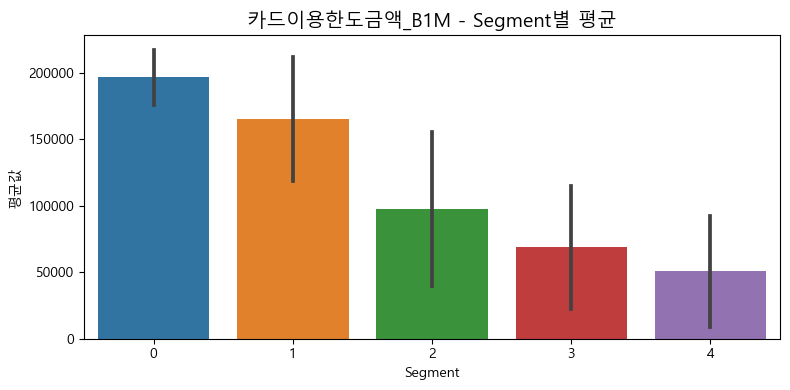

C:\Users\HR\AppData\Local\Temp\ipykernel_24964\2394508156.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=eda_df, x=segment_col, y=col, estimator='mean', ci='sd')


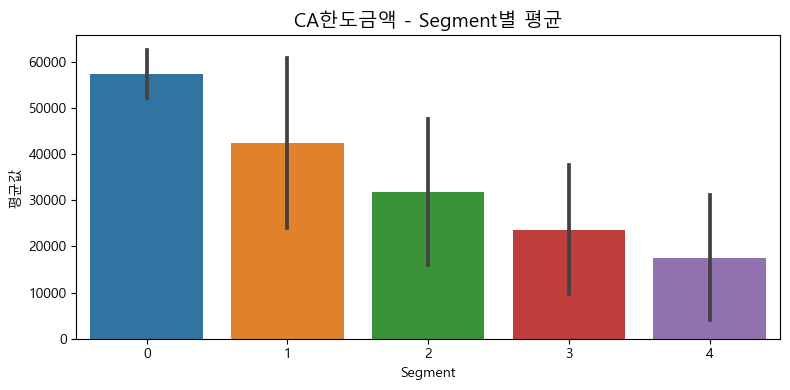

C:\Users\HR\AppData\Local\Temp\ipykernel_24964\2394508156.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=eda_df, x=segment_col, y=col, estimator='mean', ci='sd')


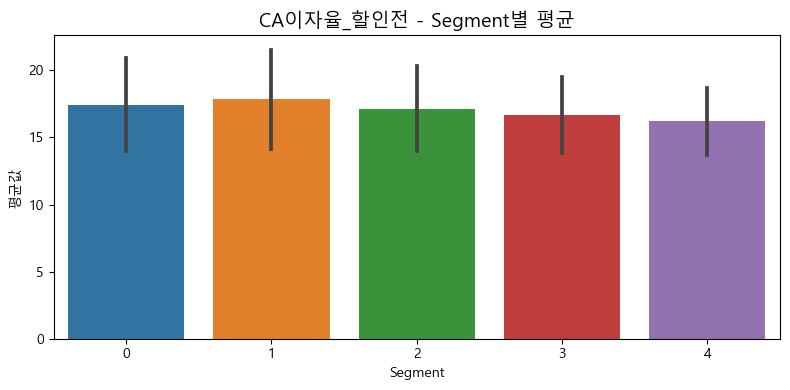

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 예시: 변수 5개만 시각화 (필요시 개수 조정)
for col in low_corr_vars[:5]:  # 또는 [:10], [:20]
    plt.figure(figsize=(8, 4))
    sns.barplot(data=eda_df, x=segment_col, y=col, estimator='mean', ci='sd')
    plt.title(f"{col} - Segment별 평균", fontsize=14)
    plt.xlabel("Segment")
    plt.ylabel("평균값")
    plt.tight_layout()
    plt.show()


C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length

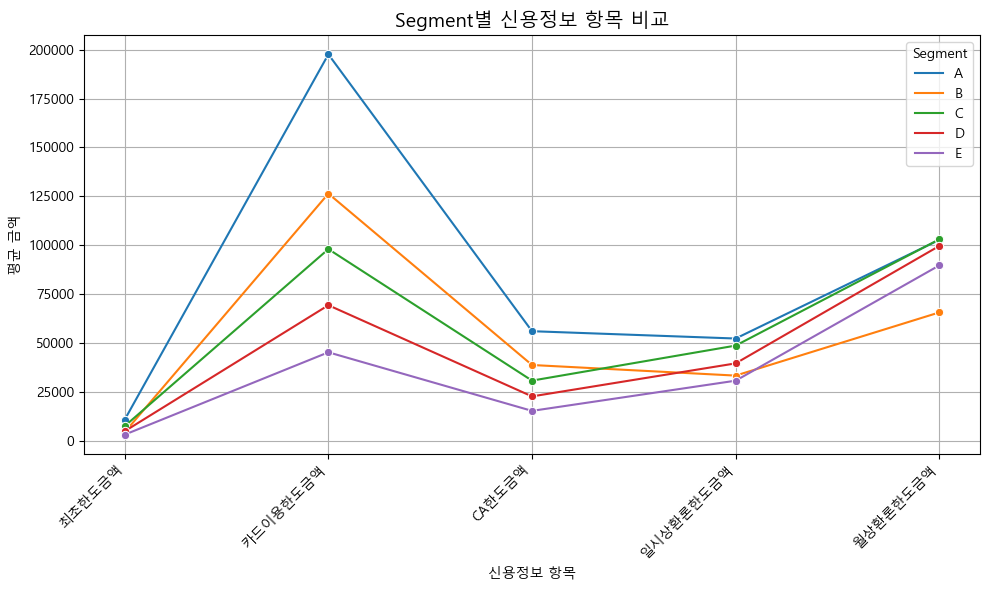

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import os

# 1. 신용정보 파일 병합
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

credit_df = load_and_merge_parquet(marketing_file_paths)

# 2. 회원정보에서 ID, Segment만 불러오기
member_df = pd.read_csv("C:/Users/HR/Desktop/workspace/파이널프로젝트/회원정보_201807_201812_통합.csv")
member_df = member_df[['ID', 'Segment']]

# 3. 병합
df = pd.merge(credit_df, member_df, on='ID', how='left')

# 4. 사용할 컬럼
cols = [
    '최초한도금액',
    '카드이용한도금액',
    'CA한도금액',
    '일시상환론한도금액',
    '월상환론한도금액'
]

# 5. Segment별 평균값 계산
segment_avg = df.groupby('Segment')[cols].mean(numeric_only=True).reset_index()

# 6. long형 변환
plot_df = segment_avg.melt(id_vars='Segment', var_name='항목', value_name='평균값')

# 7. 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 🔥 불필요한 map 제거
# plot_df['Segment'] = plot_df['Segment'].map(...)

# 8. 라인플롯 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='항목', y='평균값', hue='Segment', marker='o')

plt.title("Segment별 신용정보 항목 비교", fontsize=14)
plt.xlabel("신용정보 항목")
plt.ylabel("평균 금액")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Segment")
plt.show()



C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length

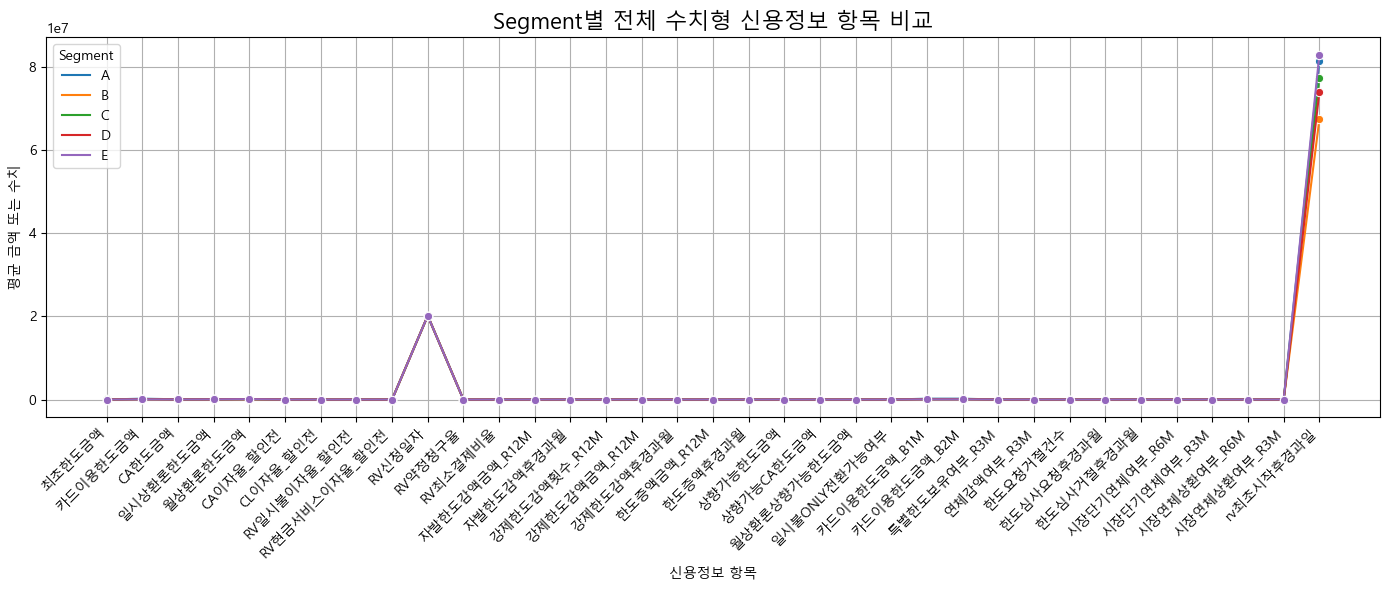

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import os

# 1. 신용정보 파일 병합
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

credit_df = load_and_merge_parquet(marketing_file_paths)

# 2. 회원정보에서 ID, Segment만 불러오기
member_df = pd.read_csv("C:/Users/HR/Desktop/workspace/파이널프로젝트/회원정보_201807_201812_통합.csv")
member_df = member_df[['ID', 'Segment']]

# 3. 병합
df = pd.merge(credit_df, member_df, on='ID', how='left')

# 4. Segment별 전체 수치형 컬럼 평균 계산
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Segment']  # Segment 제외

segment_avg = df.groupby('Segment')[numeric_cols].mean(numeric_only=True).reset_index()

# 5. long형 변환
plot_df = segment_avg.melt(id_vars='Segment', var_name='항목', value_name='평균값')

# 6. 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 7. 라인플롯 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=plot_df, x='항목', y='평균값', hue='Segment', marker='o')

plt.title("Segment별 전체 수치형 신용정보 항목 비교", fontsize=16)
plt.xlabel("신용정보 항목")
plt.ylabel("평균 금액 또는 수치")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Segment")
plt.show()


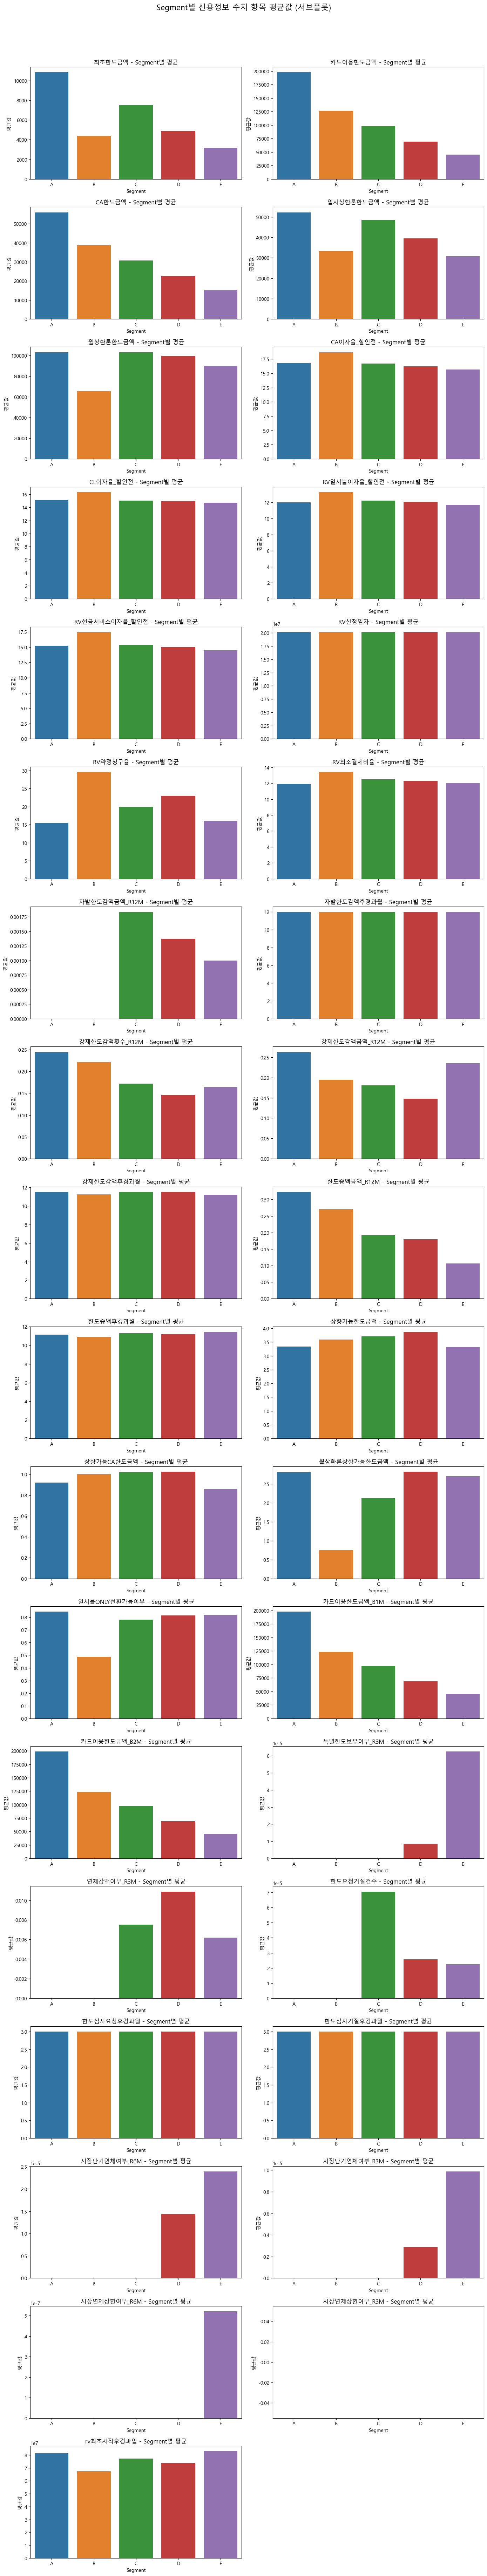

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
import math

# 1. 신용정보 파일 병합
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

credit_df = load_and_merge_parquet(marketing_file_paths)

# 2. 회원정보에서 ID, Segment만 불러오기
member_df = pd.read_csv("C:/Users/HR/Desktop/workspace/파이널프로젝트/회원정보_201807_201812_통합.csv")
member_df = member_df[['ID', 'Segment']]

# 3. 병합
df = pd.merge(credit_df, member_df, on='ID', how='left')

# 4. Segment별 전체 수치형 컬럼 평균 계산
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Segment']

segment_avg = df.groupby('Segment')[numeric_cols].mean(numeric_only=True).reset_index()

# 5. long형 변환
plot_df = segment_avg.melt(id_vars='Segment', var_name='항목', value_name='평균값')

# 6. 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 7. 서브플롯으로 나누어 시각화
unique_cols = plot_df['항목'].unique()
n_cols = 2  # 열 개수
n_rows = math.ceil(len(unique_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(unique_cols):
    ax = axes[i]
    temp = plot_df[plot_df['항목'] == col]
    sns.barplot(data=temp, x='Segment', y='평균값', ax=ax)
    ax.set_title(f"{col} - Segment별 평균", fontsize=12)
    ax.set_xlabel("Segment")
    ax.set_ylabel("평균값")

# 안 쓰는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Segment별 신용정보 수치 항목 평균값 (서브플롯)", fontsize=16, y=1.02)
plt.show()


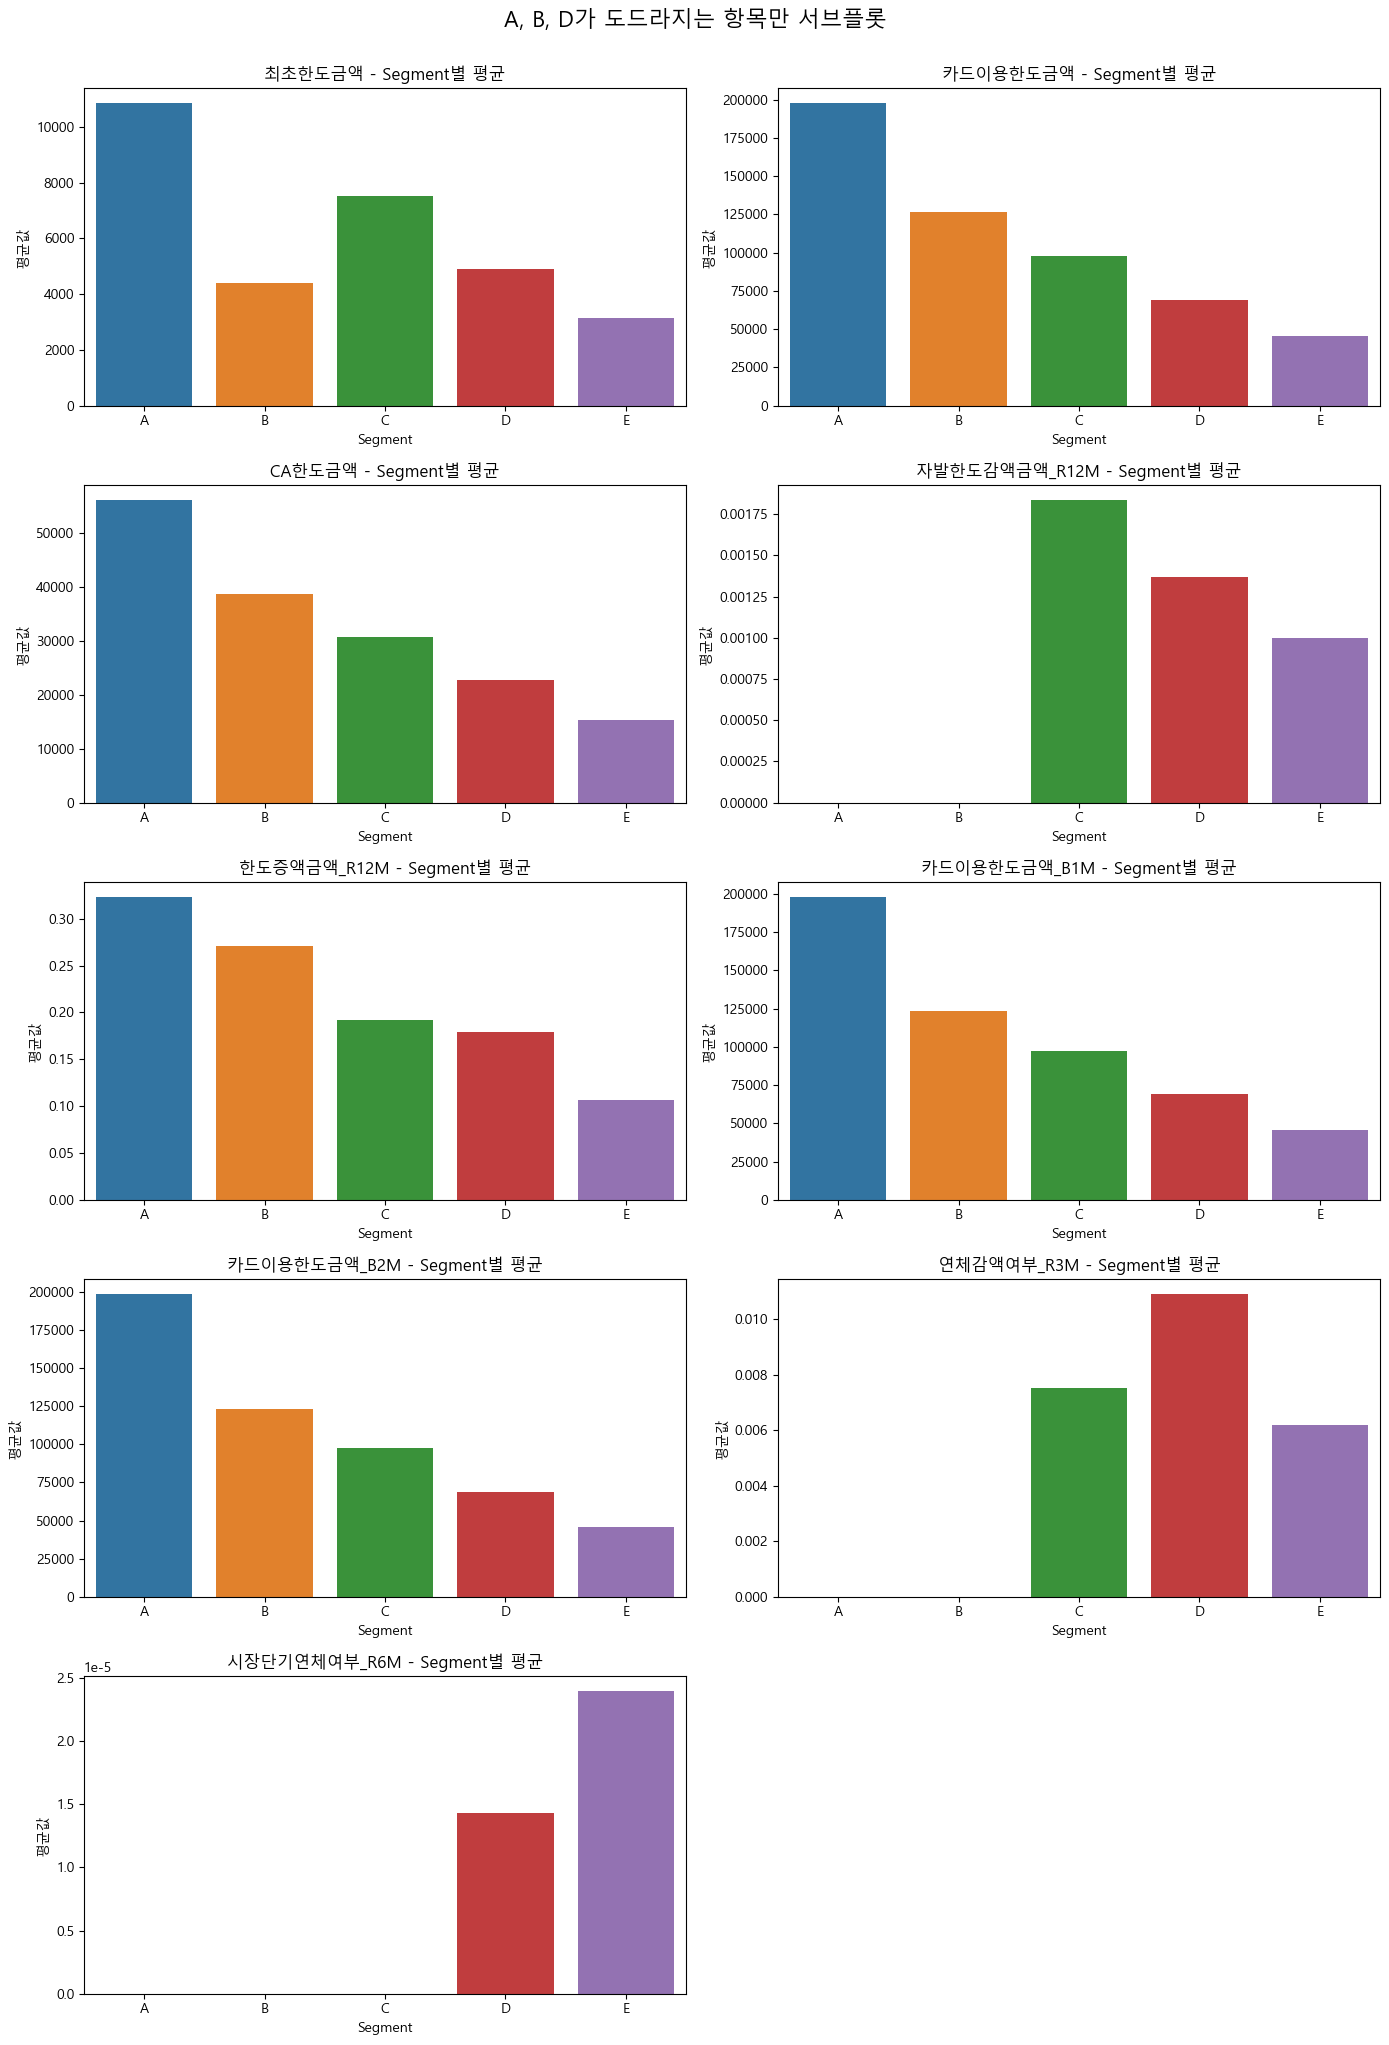

In [46]:
# 4. Segment별 전체 수치형 컬럼 평균 계산
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Segment']

segment_avg = df.groupby('Segment')[numeric_cols].mean(numeric_only=True).reset_index()

# 5. long형 변환
plot_df = segment_avg.melt(id_vars='Segment', var_name='항목', value_name='평균값')

# 🔍 A, B, D만 필터링해서 기준보다 높은 항목만 추출
ab_d = plot_df[plot_df['Segment'].isin(['A', 'B', 'D'])]

# 전체 평균값 계산
overall_mean = plot_df.groupby('항목')['평균값'].mean().reset_index().rename(columns={'평균값': '전체평균'})

# A, B, D에서 하나라도 전체 평균의 1.5배 초과하는 항목 추출
merged = pd.merge(ab_d, overall_mean, on='항목')
merged['비율'] = merged['평균값'] / merged['전체평균']
highlight_cols = merged[merged['비율'] > 1.5]['항목'].unique()

# 필터링 적용
filtered_df = plot_df[plot_df['항목'].isin(highlight_cols)]

# 6. 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 7. 서브플롯 시각화
n_cols = 2
n_rows = math.ceil(len(highlight_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(highlight_cols):
    ax = axes[i]
    temp = filtered_df[filtered_df['항목'] == col]
    sns.barplot(data=temp, x='Segment', y='평균값', ax=ax)
    ax.set_title(f"{col} - Segment별 평균", fontsize=12)
    ax.set_xlabel("Segment")
    ax.set_ylabel("평균값")

# 남은 빈 축 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("A, B, D가 도드라지는 항목만 서브플롯", fontsize=16, y=1.02)
plt.show()


C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1

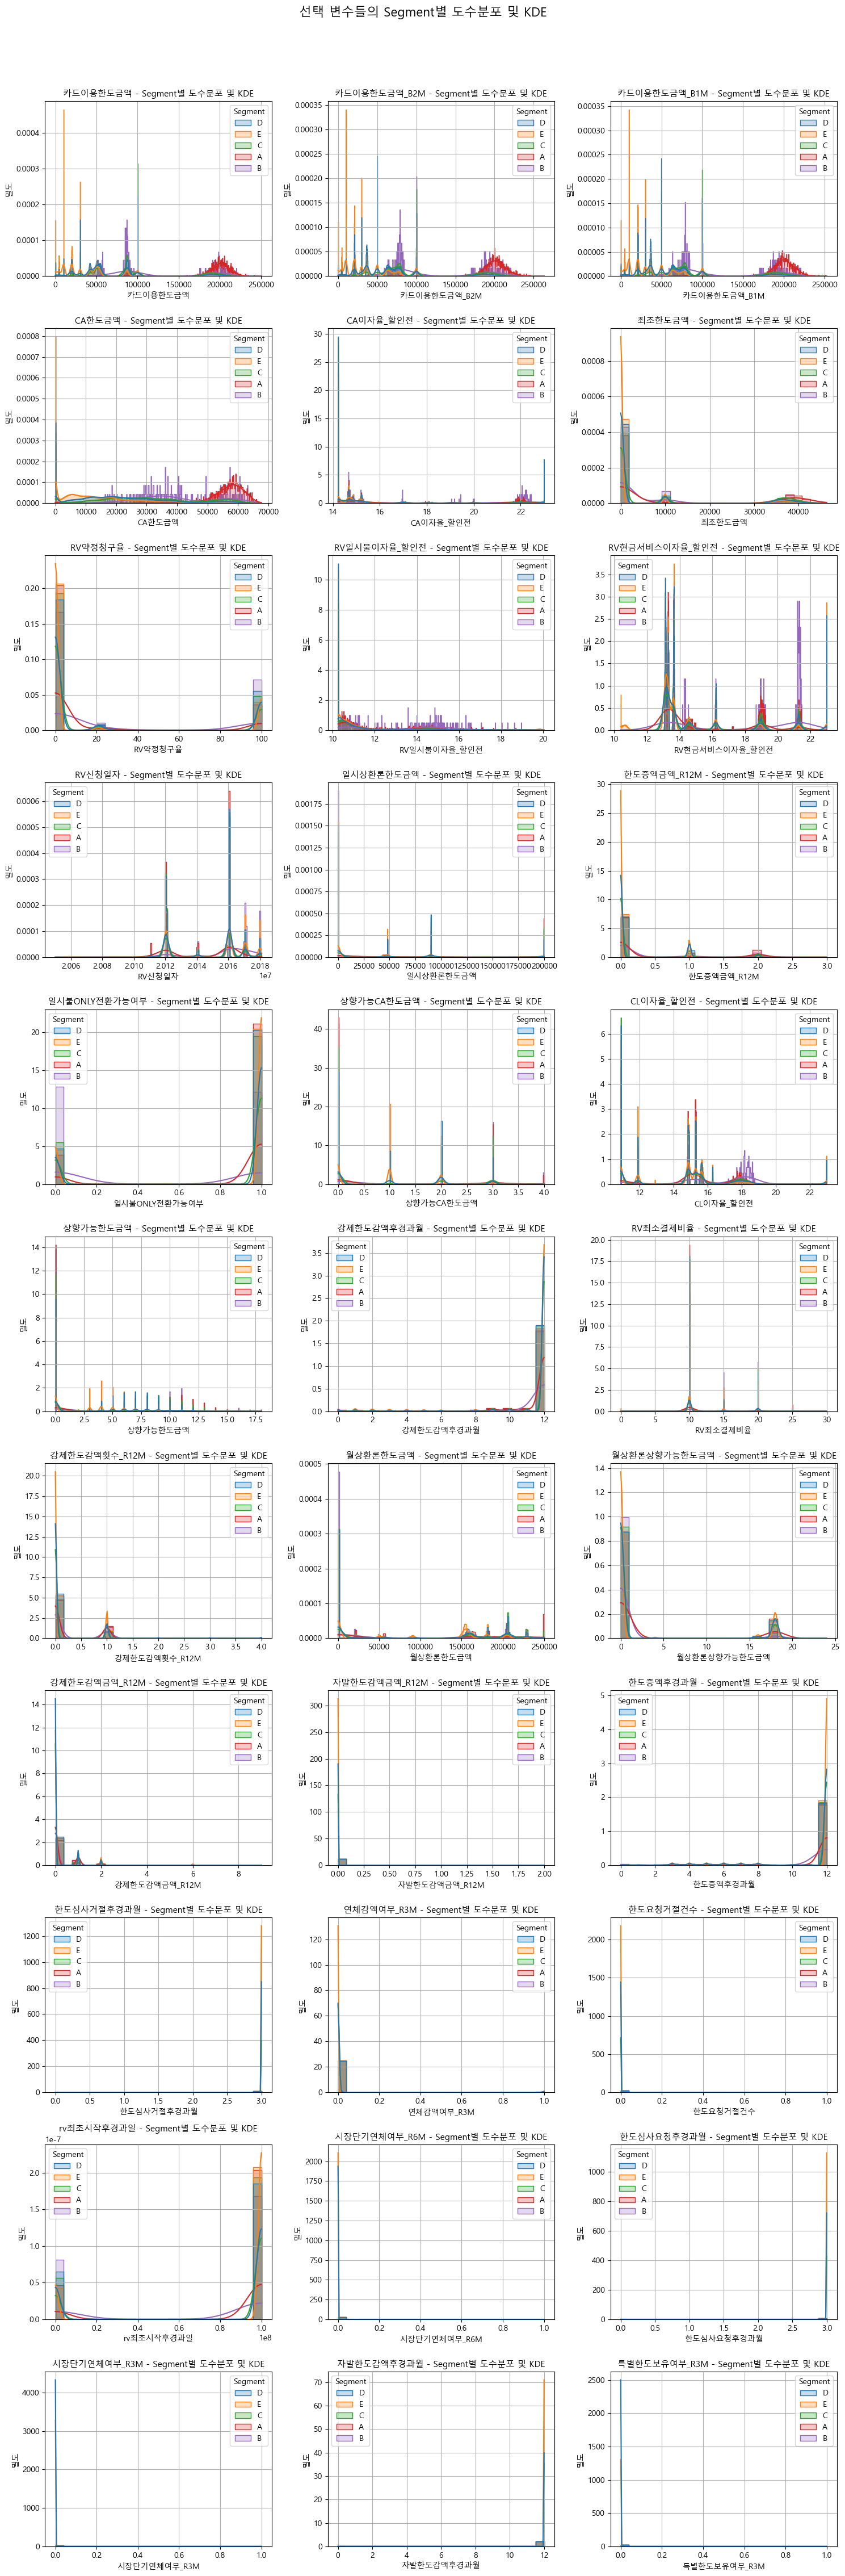

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 0. 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 신용정보 파일 경로 리스트
credit_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201807_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201808_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201809_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201810_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201811_train_신용정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/2.신용정보/201812_train_신용정보.parquet"
]

# 2. 신용정보 파일 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# 3. 신용정보 병합
credit_df = load_and_merge_parquet(credit_file_paths)

# 4. 회원정보에서 ID, Segment만 불러오기
member_df = pd.read_csv("C:/Users/HR/Desktop/workspace/파이널프로젝트/회원정보_201807_201812_통합.csv")
member_df = member_df[['ID', 'Segment']]

# 5. Segment 병합
df = credit_df.merge(member_df, on='ID', how='left')
target_cols = [
    "카드이용한도금액",
    "카드이용한도금액_B2M",
    "카드이용한도금액_B1M",
    "CA한도금액",
    "CA이자율_할인전",
    "최초한도금액",
    "RV약정청구율",
    "RV일시불이자율_할인전",
    "RV현금서비스이자율_할인전",
    "RV신청일자",
    "일시상환론한도금액",
    "한도증액금액_R12M",
    "일시불ONLY전환가능여부",
    "상향가능CA한도금액",
    "CL이자율_할인전",
    "상향가능한도금액",
    "강제한도감액후경과월",
    "RV최소결제비율",
    "강제한도감액횟수_R12M",
    "월상환론한도금액",
    "월상환론상향가능한도금액",
    "강제한도감액금액_R12M",
    "자발한도감액금액_R12M",
    "한도증액후경과월",
    "한도심사거절후경과월",
    "연체감액여부_R3M",
    "한도요청거절건수",
    "rv최초시작후경과일",
    "시장단기연체여부_R6M",
    "한도심사요청후경과월",
    "시장단기연체여부_R3M",
    "자발한도감액후경과월",
    "특별한도보유여부_R3M"
]

# 6. 위 리스트 기준으로 필터링
plot_df = df.copy()
filtered_cols = [col for col in target_cols if col in df.columns]

# 7. subplot 설정
cols = 3
rows = math.ceil(len(filtered_cols) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# 8. 히스토그램 + KDE 그리기
for i, col in enumerate(filtered_cols):
    ax = axes[i]
    sns.histplot(data=plot_df, x=col, hue='Segment', element='step',
                 stat='density', common_norm=False, kde=True, ax=ax)
    ax.set_title(f"{col} - Segment별 도수분포 및 KDE", fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel("밀도")
    ax.grid(True)

# 9. 남은 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 10. 전체 레이아웃
plt.tight_layout()
plt.suptitle("선택 변수들의 Segment별 도수분포 및 KDE", fontsize=16, y=1.03)
plt.show()


In [19]:
print(df.columns.tolist())

['기준년월', 'ID', '최초한도금액', '카드이용한도금액', 'CA한도금액', '일시상환론한도금액', '월상환론한도금액', 'CA이자율_할인전', 'CL이자율_할인전', 'RV일시불이자율_할인전', 'RV현금서비스이자율_할인전', 'RV신청일자', 'RV약정청구율', 'RV최소결제비율', '자발한도감액횟수_R12M', '자발한도감액금액_R12M', '자발한도감액후경과월', '강제한도감액횟수_R12M', '강제한도감액금액_R12M', '강제한도감액후경과월', '한도증액횟수_R12M', '한도증액금액_R12M', '한도증액후경과월', '상향가능한도금액', '상향가능CA한도금액', '카드론동의여부', '월상환론상향가능한도금액', 'RV전환가능여부', '일시불ONLY전환가능여부', '카드이용한도금액_B1M', '카드이용한도금액_B2M', '특별한도보유여부_R3M', '연체감액여부_R3M', '한도심사요청건수', '한도요청거절건수', '한도심사요청후경과월', '한도심사거절후경과월', '시장단기연체여부_R6M', '시장단기연체여부_R3M', '시장연체상환여부_R6M', '시장연체상환여부_R3M', 'rv최초시작후경과일', 'Segment']


C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HR\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


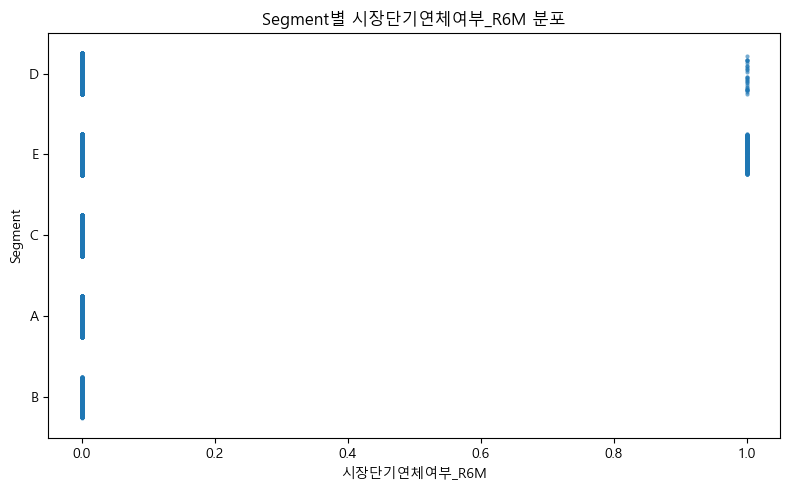

ValueError: Could not interpret value ` 최초한도금액` for parameter `x`

<Figure size 800x500 with 0 Axes>

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 변수 리스트
cols_to_plot = ['시장단기연체여부_R6M',' 최초한도금액','자발한도감액금액_R12M', '연체감액여부_R3M',]

# 4개 변수 각각에 대해 플롯
for col in cols_to_plot:
    plt.figure(figsize=(8, 5))
    sns.stripplot(data=df, x=col, y='Segment', jitter=0.25, alpha=0.6, size=3)
    plt.title(f'Segment별 {col} 분포')
    plt.xlabel(col)
    plt.ylabel('Segment')
    plt.tight_layout()
    plt.show()

In [22]:
import pandas as pd
import numpy as np

cols_to_plot = ['시장단기연체여부_R6M', '최초한도금액', '자발한도감액금액_R12M', '연체감액여부_R3M']
segment_targets = ['C', 'D', 'E']

cv_results = {}

for col in cols_to_plot:
    cv_results[col] = {}
    for seg in segment_targets:
        seg_data = df[df['Segment'] == seg][col].dropna()
        mean = seg_data.mean()
        std = seg_data.std()
        cv = std / mean if mean != 0 else float('inf')
        cv_results[col][f'CV_{seg}'] = round(cv, 3)

# 결과 보기
cv_df = pd.DataFrame(cv_results).T
cv_df['CV_Diff_D_vs_CE'] = cv_df['CV_D'] - ((cv_df['CV_C'] + cv_df['CV_E']) / 2)
cv_df = cv_df[['CV_C', 'CV_D', 'CV_E', 'CV_Diff_D_vs_CE']]

display(cv_df)



,CV_C,CV_D,CV_E,CV_Diff_D_vs_CE
시장단기연체여부_R6M,inf,264.287,204.408,-inf
최초한도금액,1.898,2.415,3.072,-0.0700
자발한도감액금액_R12M,24.499,28.035,32.996,-0.7125
연체감액여부_R3M,11.497,9.528,12.669,-2.5550
